#Time series forecast using Recurrent Neural Network.

Data available at this link: https://fred.stlouisfed.org/series/S4248SM144NCEN 

data represents the sales of Nondurable Goods(Beer, Wine, and Distilled Alcoholic Beverages) from 1992 to 2022 in the U.S with monthly frequency.

Sales values expressed in Millions of Dollars.

The goal is to create a model that can predict future sales of the goods.

In [1]:
import pandas as pd
import numpy as np
import io
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from google.colab import files
data = files.upload()

Saving S4248SM144NCEN.csv to S4248SM144NCEN.csv


In [4]:
df = pd.read_csv("S4248SM144NCEN.csv",index_col='DATE',parse_dates=True)

In [61]:
df.head(), df.tail()

(            nondurable goods sales
 DATE                              
 1992-01-01                    3459
 1992-02-01                    3458
 1992-03-01                    4002
 1992-04-01                    4564
 1992-05-01                    4221,             nondurable goods sales
 DATE                              
 2022-06-01                   17700
 2022-07-01                   15031
 2022-08-01                   16860
 2022-09-01                   16305
 2022-10-01                   15418)

In [6]:
df.rename(columns={"S4248SM144NCEN":"nondurable goods sales"},inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 370 entries, 1992-01-01 to 2022-10-01
Data columns (total 1 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   nondurable goods sales  370 non-null    int64
dtypes: int64(1)
memory usage: 5.8 KB


In [8]:
df.describe()

,nondurable goods sales
count,370.000000
mean,8678.018919
std,3550.443776
min,3031.000000
25%,5525.500000
50%,8374.000000
75%,11232.000000
max,18139.000000


In [9]:
df.isnull().sum()

nondurable goods sales    0
dtype: int64

Text(0, 0.5, 'Sales (millions of dollars)')

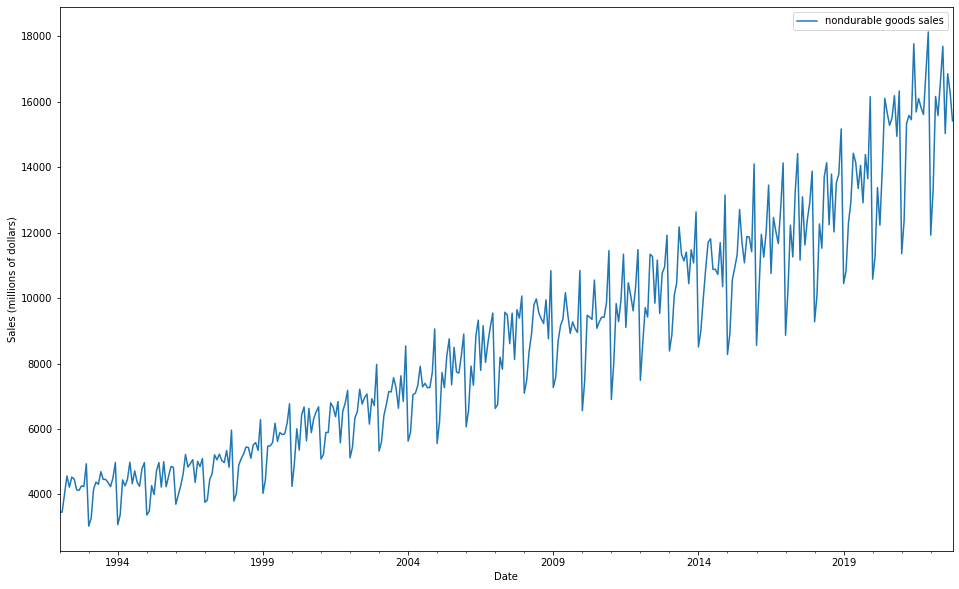

In [10]:
df.plot(figsize=(16,10))
plt.xlabel('Date')
plt.ylabel('Sales (millions of dollars)')

# Train/test split 

In [11]:
len(df)

370

In [12]:
len(df)-12

358

In [13]:
test_size= 12

In [14]:
test_ind= len(df)- test_size

In [15]:
train= df.iloc[:test_ind]
test= df.iloc[test_ind:]

# Scaling our data

In [16]:
from sklearn.preprocessing import MinMaxScaler

In [17]:
scaler = MinMaxScaler()

In [18]:
scaler.fit(train)

MinMaxScaler()

In [19]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

# Time series generator

In [20]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [21]:
length = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

## Creating model RNN with LSTM

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM

In [23]:
n_features = 1

In [24]:
model = Sequential()
model.add(LSTM(100, activation='relu',input_shape=(length,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')
    


In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [26]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test,length=11,batch_size=1)

In [28]:
model.fit(generator,epochs=50)

Epoch 1/50
346/346 [==============================] - 2s 7ms/step - loss: 0.0012
Epoch 2/50
346/346 [==============================] - 2s 7ms/step - loss: 0.0013
Epoch 3/50
346/346 [==============================] - 2s 7ms/step - loss: 0.0012
Epoch 4/50
346/346 [==============================] - 2s 7ms/step - loss: 0.0014
Epoch 5/50
346/346 [==============================] - 2s 7ms/step - loss: 0.0013
Epoch 6/50
346/346 [==============================] - 2s 7ms/step - loss: 0.0013
Epoch 7/50
346/346 [==============================] - 2s 7ms/step - loss: 0.0014
Epoch 8/50
346/346 [==============================] - 2s 7ms/step - loss: 0.0012
Epoch 9/50
346/346 [==============================] - 2s 7ms/step - loss: 0.0013
Epoch 10/50
346/346 [==============================] - 2s 7ms/step - loss: 0.0013
Epoch 11/50
346/346 [==============================] - 2s 7ms/step - loss: 0.0012
Epoch 12/50
346/346 [==============================] - 2s 7ms/step - loss: 0.0012
Epoch 13/50
346/346 [====

In [29]:
losses = pd.DataFrame(model.history.history)

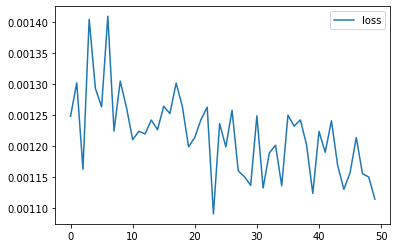

In [31]:
losses.plot()

# LSTM Predictions

In [32]:
test_predictions = []
first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
  current_pred = model.predict(current_batch)[0]
  test_predictions.append(current_pred)
  current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 21ms/step


In [33]:
true_predictions = scaler.inverse_transform(test_predictions)

In [34]:
test['Predictions'] = true_predictions

<ipython-input-34-920b79c3c314>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [35]:
test

,nondurable goods sales,Predictions
DATE,,
2021-11-01,16896,15722.635118
2021-12-01,18139,16560.873664
2022-01-01,11926,12287.794809
2022-02-01,13333,13888.553695
2022-03-01,16165,15726.447658
2022-04-01,15584,15988.141892
2022-05-01,16600,16354.407652
2022-06-01,17700,17851.690084
2022-07-01,15031,16247.062410


Text(0, 0.5, 'Sales (millions of dollars)')

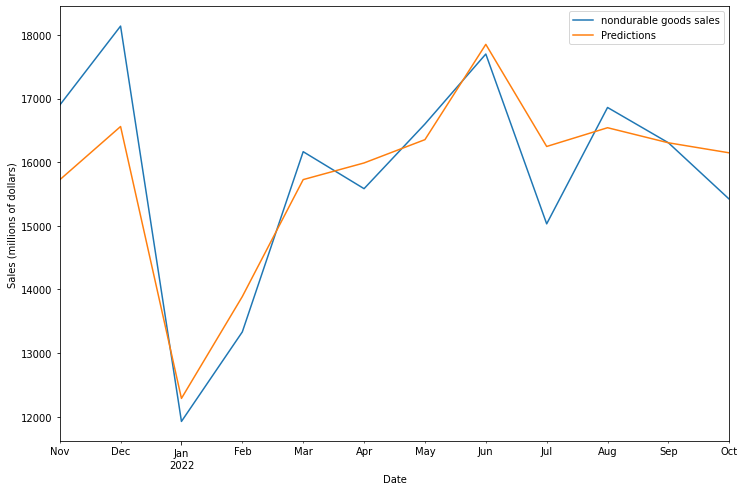

In [36]:
test.plot(figsize=(12,8))
plt.xlabel('Date')
plt.ylabel('Sales (millions of dollars)')

# Calculating the RMSE

In [37]:
from sklearn.metrics import mean_squared_error

In [38]:
np.sqrt(mean_squared_error(test['nondurable goods sales'],test['Predictions']))

755.9282707878497

In [46]:
test.mean()



nondurable goods sales    15829.750000
Predictions               15801.770227
dtype: float64

In [60]:
((755.92*100)/15829.75)

4.775312307522229

RMSE is around 4,77 % of the mean value of sales. 

In conclusion, the model is able to predict the trend and the values of sales with a discrete accuracy.